# InceptionResnetV2

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random

In [2]:
import cv2
import matplotlib.pyplot as plt 

In [3]:
PATH = Path("/home/ubuntu/data/sandwich/")

In [4]:
# list(PATH.iterdir())

In [5]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

# Data augmentation

In [6]:
import math
def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]


# random crop to the original size
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)


def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, 
                          flags=cv2.WARP_FILL_OUTLIERS+interpolation)

# Train-validation split

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
def get_files(path):
    paths = [d for d in list(path.iterdir()) if d.is_dir()]
    files = [f for d in paths for f in list(d.iterdir())]
    return files

In [9]:
path = PATH/"train-315"

In [10]:
files = get_files(path)

In [11]:
# files

In [12]:
file_labels = [p.parts[-2] for p in files]

In [13]:
train_files, valid_files, y_train, y_valid = train_test_split(files, file_labels, test_size=0.2, random_state=42)

In [14]:
# from collections import Counter

In [15]:
# Counter(y_train), Counter(y_valid)

# Dataset

In [16]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [17]:
paths = [d for d in list(path.iterdir()) if d.is_dir()]

In [18]:
labels = [p.parts[-1] for p in paths]

In [19]:
labels

['hot_dog',
 'pulled_pork_sandwich',
 'grilled_cheese_sandwich',
 'lobster_roll_sandwich',
 'hamburger',
 'club_sandwich']

In [20]:
class SandwichDataset(Dataset):
    def __init__(self, files, labels, transforms=False):
        self.files = files
        self.label2ind = {v:k for k,v in enumerate(labels)}
        self.transforms = transforms
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        path = self.files[idx]
        name = path.parts[-1]
        y_class = self.label2ind[path.parts[-2]]
        x = cv2.imread(str(path)).astype(np.float32)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
        if self.transforms:
            rdeg = (np.random.random()-.50)*20
            x = rotate_cv(x, rdeg)
            if np.random.random() > 0.5: x = np.fliplr(x).copy()
            x = random_crop(x)
        else:
            x = center_crop(x)
        x = normalize(x)
        y = self.label2ind[path.parts[-2]]
        return np.rollaxis(x, 2), y

In [21]:
train_ds = SandwichDataset(files=train_files, labels=labels, transforms=True)

In [22]:
valid_ds = SandwichDataset(files=valid_files, labels=labels, transforms=False)

In [23]:
# len(train_ds), len(valid_ds)

In [24]:
x, y = train_ds[0]

In [25]:
# x.shape, y

In [26]:
batch_size = 50

In [27]:
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [28]:
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

In [29]:
x, y = next(iter(train_dl))

In [30]:
x = x.cuda().float()
y = y.cuda()

In [31]:
# x.shape, y.shape

In [32]:
# y.shape[0]

# Initialize pre-trained model with frozen hidden layers

In [33]:
# ! pip install pretrainedmodels

In [34]:
import pretrainedmodels

In [35]:
# model_name = 'inceptionresnetv2'

In [36]:
# model = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')

In [37]:
downloaded_model_path = Path("/home/ubuntu/models/sandwich/downloaded_inceptionresnetv2.pth")

In [38]:
# torch.save(model, downloaded_model_path)

In [39]:
inception_resnet = torch.load(downloaded_model_path)

In [40]:
layers = list(inception_resnet.children())

In [41]:
print(len(layers))

17


In [42]:
# layers[10]

In [43]:
inception_resnet.last_linear

Linear(in_features=1536, out_features=1000, bias=True)

In [44]:
class InceptionResnet(nn.Module):
    def __init__(self):
        super(InceptionResnet, self).__init__()
        model = torch.load(Path("/home/ubuntu/models/sandwich/downloaded_inceptionresnetv2.pth"))
        # freezing parameters
        for param in model.parameters():
            param.requires_grad = False
        layers = list(model.children())[:16]
        self.top_model = nn.Sequential(*layers).cuda()
        self.fc = nn.Linear(1536, 6)
    
    def forward(self, x):
        x = self.top_model(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

In [45]:
model = InceptionResnet().cuda()

In [46]:
out = model(x)

In [47]:
# out.shape

In [48]:
# _, pred = torch.max(out, 1)

In [49]:
# pred

In [50]:
# y

In [51]:
# pred.eq(y).sum()

In [52]:
F.cross_entropy(out, y).item()

1.8028912544250488

# Compute accuracy

In [53]:
def val_metrics(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for x, y in valid_dl:
        batch = y.shape[0]
        x = x.cuda().float()
        y = y.cuda()
        out = model(x)
        _, pred = torch.max(out, 1)
        correct += pred.eq(y).sum().item()
        loss = F.cross_entropy(out, y)
        sum_loss += batch*(loss.item())
        total += batch
    return sum_loss/total, correct/total

In [54]:
# val_metrics(model, valid_dl)

# Train model with fixed learning rate for 10 epochs

In [55]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

In [56]:
model_path = Path("/home/ubuntu/models/sandwich/")

In [57]:
def get_optimizer(model, lr=0.01, wd=0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch.optim.Adam(parameters, lr=lr, weight_decay=wd)
    return optim

def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

In [58]:
def train(model, epochs=5, learning_rate=0.01):
    optimzer = get_optimizer(model, lr=learning_rate, wd=0)
    prev_val_acc = 0.0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y in train_dl:
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            _, pred = torch.max(out, 1)
            loss = F.cross_entropy(out, y)
            optimzer.zero_grad()
            loss.backward()
            optimzer.step()
            total += batch
            sum_loss += batch*(loss.item())
        val_loss, val_acc = val_metrics(model, valid_dl)
        if i % 2 == 0:
            print("train loss %.3f val loss %.3f val accuracy %.3f" % (sum_loss/total, val_loss, val_acc))
        if val_acc > prev_val_acc:
            prev_val_acc = val_acc
            if val_acc > 0.6:
                path = "{0}/initial_inceptionresnet_{1:.0f}.pth".format(model_path, 100*val_acc)
                save_model(model, path)
                print(path)

In [59]:
model = InceptionResnet().cuda()

In [60]:
train(model, epochs=10, learning_rate=0.01)

train loss 1.446 val loss 1.091 val accuracy 0.609
/home/ubuntu/models/sandwich/initial_inceptionresnet_61.pth
train loss 0.917 val loss 0.967 val accuracy 0.646
/home/ubuntu/models/sandwich/initial_inceptionresnet_65.pth
/home/ubuntu/models/sandwich/initial_inceptionresnet_67.pth
train loss 0.896 val loss 0.887 val accuracy 0.708
/home/ubuntu/models/sandwich/initial_inceptionresnet_71.pth
train loss 0.794 val loss 0.882 val accuracy 0.690
train loss 0.886 val loss 0.963 val accuracy 0.660


In [61]:
# save_model(model, model_path/"initial_inceptionresnet.pth")

# Unfreeze top 4 hidden layers, train with lower learning rate for additional 20 epochs

In [72]:
model = InceptionResnet().cuda()

In [73]:
load_model(model, model_path/"initial_inceptionresnet_71.pth")

In [74]:
val_metrics(model, valid_dl)

(0.8871086372269524, 0.7077777777777777)

In [75]:
def set_trainable_attr(m, b=True):
    for p in m.parameters(): p.requires_grad = b

In [76]:
def unfreeze(model, l):
    top_model = model.top_model
    set_trainable_attr(top_model[l])

In [77]:
unfreeze(model, 15)
unfreeze(model, 14)
unfreeze(model, 13)
unfreeze(model, 12)

In [78]:
def train2(model, epochs=5, learning_rate=0.01):
    optimzer = get_optimizer(model, lr=learning_rate, wd=0)
    prev_val_acc = 0.0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y in train_dl:
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            _, pred = torch.max(out, 1)
            loss = F.cross_entropy(out, y)
            optimzer.zero_grad()
            loss.backward()
            optimzer.step()
            total += batch
            sum_loss += batch*(loss.item())
        val_loss, val_acc = val_metrics(model, valid_dl)
        if i % 2 == 0:
            print("train loss %.3f val loss %.3f val accuracy %.3f" % (sum_loss/total, val_loss, val_acc))
        if val_acc > prev_val_acc:
            prev_val_acc = val_acc
            if val_acc > 0.7:
                path = "{0}/unfreeze_inceptionresnet_{1:.0f}.pth".format(model_path, 100*val_acc)
                save_model(model, path)
                print(path)

In [79]:
train2(model, epochs=20, learning_rate=0.001)

train loss 0.883 val loss 0.695 val accuracy 0.769
/home/ubuntu/models/sandwich/unfreeze_inceptionresnet_77.pth
/home/ubuntu/models/sandwich/unfreeze_inceptionresnet_78.pth
train loss 0.275 val loss 0.750 val accuracy 0.782
/home/ubuntu/models/sandwich/unfreeze_inceptionresnet_78.pth
/home/ubuntu/models/sandwich/unfreeze_inceptionresnet_80.pth
train loss 0.193 val loss 0.706 val accuracy 0.800
/home/ubuntu/models/sandwich/unfreeze_inceptionresnet_82.pth
train loss 0.107 val loss 1.038 val accuracy 0.782
train loss 0.124 val loss 0.867 val accuracy 0.817
/home/ubuntu/models/sandwich/unfreeze_inceptionresnet_82.pth
train loss 0.053 val loss 0.950 val accuracy 0.802
train loss 0.053 val loss 1.355 val accuracy 0.797
train loss 0.057 val loss 1.006 val accuracy 0.813
train loss 0.042 val loss 0.816 val accuracy 0.836
/home/ubuntu/models/sandwich/unfreeze_inceptionresnet_84.pth
train loss 0.039 val loss 1.340 val accuracy 0.813


In [57]:
model = InceptionResnet().cuda()

In [58]:
load_model(model, model_path/"unfreeze_inceptionresnet_84.pth")

In [59]:
val_metrics(model, valid_dl)

(0.8160330586963229, 0.8355555555555556)

# Learning rate range test

In [80]:
def LR_range_finder(model, train_dl, lr_low=1e-5, lr_high=0.1, epochs=5):
    losses = []
    p = model_path/"inceptionresnet_tmp.pth"
    save_model(model, str(p))
    iterations = epochs * len(train_dl)
    delta = (lr_high - lr_low)/iterations
    lrs = [lr_low + i*delta for i in range(iterations)]
    model.train()
    ind = 0
    optimizer = get_optimizer(model, lr=lrs[0], wd=0.0)
    for i in range(epochs):
        for x, y in train_dl:
            update_optimizer(optimizer, lr=lrs[ind])
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            loss = F.cross_entropy(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            ind += 1
            
    load_model(model, str(p))
    return lrs, losses

In [81]:
model = InceptionResnet().cuda()

In [82]:
lrs, losses = LR_range_finder(model, train_dl)

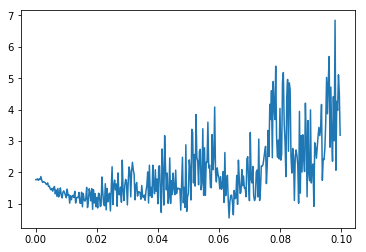

In [83]:
plt.plot(lrs, losses)
plt.show()

# Discriminative fine-tuning, gradual unfreezing, and 1-cycle triangular learning rate

In [58]:
def cosine_segment(start_lr, end_lr, iterations):
    i = np.arange(iterations)
    c_i = 1 + np.cos(i*np.pi/iterations)
    return end_lr + (start_lr - end_lr)/2 *c_i

def get_cosine_triangular_lr(max_lr, iterations):
    min_start, min_end = max_lr/25, max_lr/(25*1e4)
    iter1 = int(0.3*iterations)
    iter2 = iterations - iter1
    segs = [cosine_segment(min_start, max_lr, iter1), cosine_segment(max_lr, min_end, iter2)]
    return np.concatenate(segs)

In [59]:
def create_optimizer(model, lr0):
    param_groups = [list(model.groups[i].parameters()) for i in range(3)] # Different parameters groups for optimizer
    params = [{'params':p, 'lr': lr} for p,lr in zip(param_groups, [lr0/9, lr0/3, lr0])] # Different learning rates for groups
    return optim.Adam(params)

def update_optimizer(optimizer, group_lrs):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = group_lrs[i]

In [60]:
class InceptionResnetV2(nn.Module):
    def __init__(self):
        super(InceptionResnetV2, self).__init__()
        model = torch.load(Path("/home/ubuntu/models/sandwich/downloaded_inceptionresnetv2.pth"))
        # freezing parameters
        for param in model.parameters():
            param.requires_grad = False
        layers = list(model.children())[:16]
        self.groups = nn.ModuleList([nn.Sequential(*h) for h in [layers[:12], layers[12:]]])
        self.groups.append(nn.Linear(1536, 6))
    
    def forward(self, x):
        for group in self.groups[:2]:
            x = group(x)
        x = F.relu(x)
        x = x.view(x.shape[0], -1)
        x = self.groups[2](x) # Linear layer
        return x
    
    def freeze(self):
        for param in self.resnet.parameters():
            param.requires_grad = False
            
    def unfreeze(self, group_idx:int): # Unfreeze a group
        group = self.groups[group_idx]
        parameters = filter(lambda x: hasattr(x,'requires_grad'), group.parameters())
        for p in parameters: 
            p.requires_grad = True

## 1-cycle rate training, unfreeze top hidden layers, train for 30 epochs

In [68]:
def train_triangular_policy2(model, train_dl, valid_dl, max_lr=0.03, epochs=10):
    idx = 0
    iterations = epochs*len(train_dl)
    lrs = get_cosine_triangular_lr(max_lr, iterations)
    optimizer = create_optimizer(model, lrs[0])
    prev_val_acc = 0.0
    for j in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for i, (x, y) in enumerate(train_dl):
            lr = lrs[idx]
            update_optimizer(optimizer, [lr/9, lr/3, lr]) # In each iteration, update group learning rates
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            loss = F.cross_entropy(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            if idx == int(0.1*iterations):
                model.unfreeze(1)
                print(idx, "unfreezing 1")
            total += batch
            sum_loss += batch*(loss.item())
        train_loss = sum_loss/total
        val_loss, val_acc = val_metrics(model, valid_dl)
        print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))
        if val_acc > prev_val_acc: 
            prev_val_acc = val_acc
            if val_acc > 0.7:
                path = "{0}/ft_inceptionresnet_{1:.0f}.pth".format(model_path, 100*val_acc)
                save_model(model, path)
                print(path)
    return sum_loss/total

In [69]:
model = InceptionResnetV2().cuda()

In [70]:
val_metrics(model, valid_dl)

(1.8491163055102031, 0.1411111111111111)

In [71]:
batch_size = 50

In [72]:
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [73]:
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

In [74]:
train_triangular_policy2(model, train_dl, valid_dl, max_lr=0.03, epochs=30)

train_loss 1.423 val_loss 1.146 val_acc 0.604
train_loss 1.106 val_loss 1.028 val_acc 0.626
216 unfreezing 1
train_loss 0.998 val_loss 0.879 val_acc 0.693
train_loss 1.340 val_loss 15.743 val_acc 0.471
train_loss 0.810 val_loss 0.736 val_acc 0.769
/home/ubuntu/models/sandwich/ft_inceptionresnet_77.pth
train_loss 0.596 val_loss 1.637 val_acc 0.589
train_loss 0.537 val_loss 0.877 val_acc 0.740
train_loss 0.473 val_loss 0.835 val_acc 0.774
/home/ubuntu/models/sandwich/ft_inceptionresnet_77.pth
train_loss 0.448 val_loss 0.992 val_acc 0.766
train_loss 0.401 val_loss 0.641 val_acc 0.797
/home/ubuntu/models/sandwich/ft_inceptionresnet_80.pth
train_loss 0.325 val_loss 0.742 val_acc 0.790
train_loss 0.257 val_loss 0.803 val_acc 0.796
train_loss 0.206 val_loss 0.636 val_acc 0.818
/home/ubuntu/models/sandwich/ft_inceptionresnet_82.pth
train_loss 0.180 val_loss 0.718 val_acc 0.802
train_loss 0.174 val_loss 0.852 val_acc 0.814
train_loss 0.150 val_loss 0.811 val_acc 0.816
train_loss 0.097 val_loss 

0.016452206832304403

In [75]:
model = InceptionResnetV2().cuda()

In [77]:
load_model(model, model_path/"ft_inceptionresnet_85.pth")

In [78]:
val_metrics(model, valid_dl)

(1.3072368800640106, 0.8455555555555555)